## Bibliotecas Utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import regex as re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from operator import itemgetter

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [8]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

# Carregando os dados 

In [31]:
politicos = {}
lista_dir = os.listdir("./politicos/")
nome_politicos = []
for nome in lista_dir:
    politicos[nome[:-4]] = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    nome_politicos.append(nome[:-4])

In [38]:
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)

In [39]:
df_politicos

created_at                                               text  \
0     2021-04-19T16:18:20Z  RT @MBLivre: Presidente americano Joe Biden an...   
1     2021-04-19T16:05:53Z  Temos que fazer a nossa parte. Não podemos dei...   
2     2021-04-19T15:32:40Z  O governo federal e o Congresso ignoraram no O...   
3     2021-04-19T12:53:14Z  RT @o_antagonista: .@joaoamoedonovo sugeriu no...   
4     2021-04-19T12:25:58Z                     Informações de @OGloboPolitica   
...                    ...                                                ...   
1290  2019-04-04T16:21:34Z  Uma foto que diz muito. Orgulho da Força Nacio...   
1291  2019-04-04T13:39:55Z  Quero explicar aqui o projeto de lei anticrime...   
1292  2019-04-04T13:39:13Z  Nem sempre poderei estar por aqui, pois o trab...   
1293  2019-04-04T13:37:30Z  Resolvi aderir ao twitter pois é um instrument...   
1294  2019-04-04T13:36:29Z  Ola, bom dia, há muitas páginas de apoio e até...   

                       id    nome  
0     1384179569712713735  Amoedo  
1     1384176435552608259  Amoedo  
2     1384168077697314825  Amoedo  
3     1384127951311040517  Amoedo  
4     1384121090243383296  Amoedo  
...                   ...     ...  
1290  1113839032813879301    Moro  
1291  1113798354134347777    Moro  
1292  1113798178581696513    Moro  
1293  1113797744861360128    Moro  
1294  1113797489562460160    Moro  

[31633 rows x 4 columns]

In [34]:
print(len(nome_politicos))
print(type(politicos['Doria']))
politicos['Doria'].head()

11
<class 'pandas.core.frame.DataFrame'>


created_at                                               text  \
0  2021-04-19T13:04:16Z  São ao todo 41 milhões e 400 mil doses da vaci...   
1  2021-04-19T13:04:15Z  Estive hoje, às 5h30 da manhã, no Aeroporto de...   
2  2021-04-19T10:03:50Z  Insumos para mais 5 milhões de doses da Vacina...   
3  2021-04-19T09:17:48Z  Bom dia, pessoal. Estamos em Guarulhos receben...   
4  2021-04-19T01:28:03Z  A operação Paz e Proteção impediu a realização...   

                    id  
0  1384130730851135495  
1  1384130727348867079  
2  1384085323588665344  
3  1384073738887438337  
4  1383955522076827650

## Unindo Doria(1), Bolsonaro(2) e Lula(3) em um dataframe

In [4]:
# stopwords e simbolos a retirar
stop_words = set(['de','a','o','que','e','é','do','da','em','um','para','com','não','uma','os','no','se','na','por','mais','as','dos','como','mas','ao','ele','das','à','seu','sua','ou','quando','muito','nos','já','eu','também','só','pelo','pela','até','isso','ela','entre','depois','sem','mesmo','aos','seus','quem','nas','me','esse','eles','você','essa','num','nem','suas','meu','às','minha','numa','pelos','elas','qual','nós','lhe','deles','essas','esses','pelas','este','dele','tu','te','vocês','vos','lhes','meus','minhas','teu','tua','teus','tuas','nosso','nossa','nossos','nossas','dela','delas','esta','estes','estas','aquele','aquela','aqueles','aquelas','isto','aquilo','estou','está','estamos','estão','estive','esteve','estivemos','estiveram','estava','estávamos','estavam','estivera','estivéramos','esteja','estejamos','estejam','estivesse','estivéssemos','estivessem','estiver','estivermos','estiverem','hei','há','havemos','hão','houve','houvemos','houveram','houvera','houvéramos','haja','hajamos','hajam','houvesse','houvéssemos','houvessem','houver','houvermos','houverem','houverei','houverá','houveremos','houverão','houveria','houveríamos','houveriam','sou','somos','são','era','éramos','eram','fui','foi','fomos','foram','fora','fôramos','seja','sejamos','sejam','fosse','fôssemos','fossem','for','formos','forem','serei','será','seremos','serão','seria','seríamos','seriam','tenho','tem','temos','tém','tinha','tínhamos','tinham','tive','teve','tivemos','tiveram','tivera','tivéramos','tenha','tenhamos','tenham','tivesse','tivéssemos','tivessem','tiver','tivermos','tiverem','terei','terá','teremos','terão','teria','teríamos','teriam'])

symbols = set(['-', 'r$', 'R$', '.'])

# Doria
# separando as palavras
palavras = "".join(politicos['Doria']['text']).lower().split()
# returando stopwords e depois os web links
palavras = [w for w in palavras if not w in (stop_words | symbols)]
palavras = [w for w in palavras if re.match(r'https://*', w) == None]

c = Counter(palavras)
# retirando palavras com frequencia menor do que 5 e adicionando número ao candidato
dados = {(1,x,y) for x,y in zip(c,c.values()) if y > 5}
print("Doria", len(dados))

# Bolsonaro
palavras = "".join(politicos['Bolsonaro']['text']).lower().split()
palavras = [w for w in palavras if not w in (stop_words | symbols)]
palavras = [w for w in palavras if re.match(r'https://*', w) == None]

c = Counter(palavras)
d = {(2,x,y) for x,y in zip(c,c.values()) if y > 5}
print("Bolsonaro", len(d))
# adicionando aos dados
for x in d:
    dados.add(x)

# Lula
palavras = "".join(politicos['Lula']['text']).lower().split()
palavras = [w for w in palavras if not w in (stop_words | symbols)]
palavras = [w for w in palavras if re.match(r'https://*', w) == None]

c = Counter(palavras)
d = {(3,x,y) for x,y in zip(c,c.values()) if y > 5}
print("Lula", len(d))
for x in d:
    dados.add(x)

print("Total", len(dados))

# montando o dataframe
df = pd.DataFrame(dados, columns=['candidato', 'texto', 'frequencia'])
df.sort_values('frequencia', ascending=False)

Doria 1559
Bolsonaro 1475
Lula 1633
Total 4667


candidato         texto  frequencia
3219          3          lula         602
497           1            sp         452
3821          1       governo         445
1071          1       vacinar         435
2298          1           vou         418
...         ...           ...         ...
2456          3         marco           6
1726          3           des           6
4100          3  ilegalidades           6
2750          3      justiça,           6
1289          2      médicos,           6

[4667 rows x 3 columns]

## WordCloud de todos

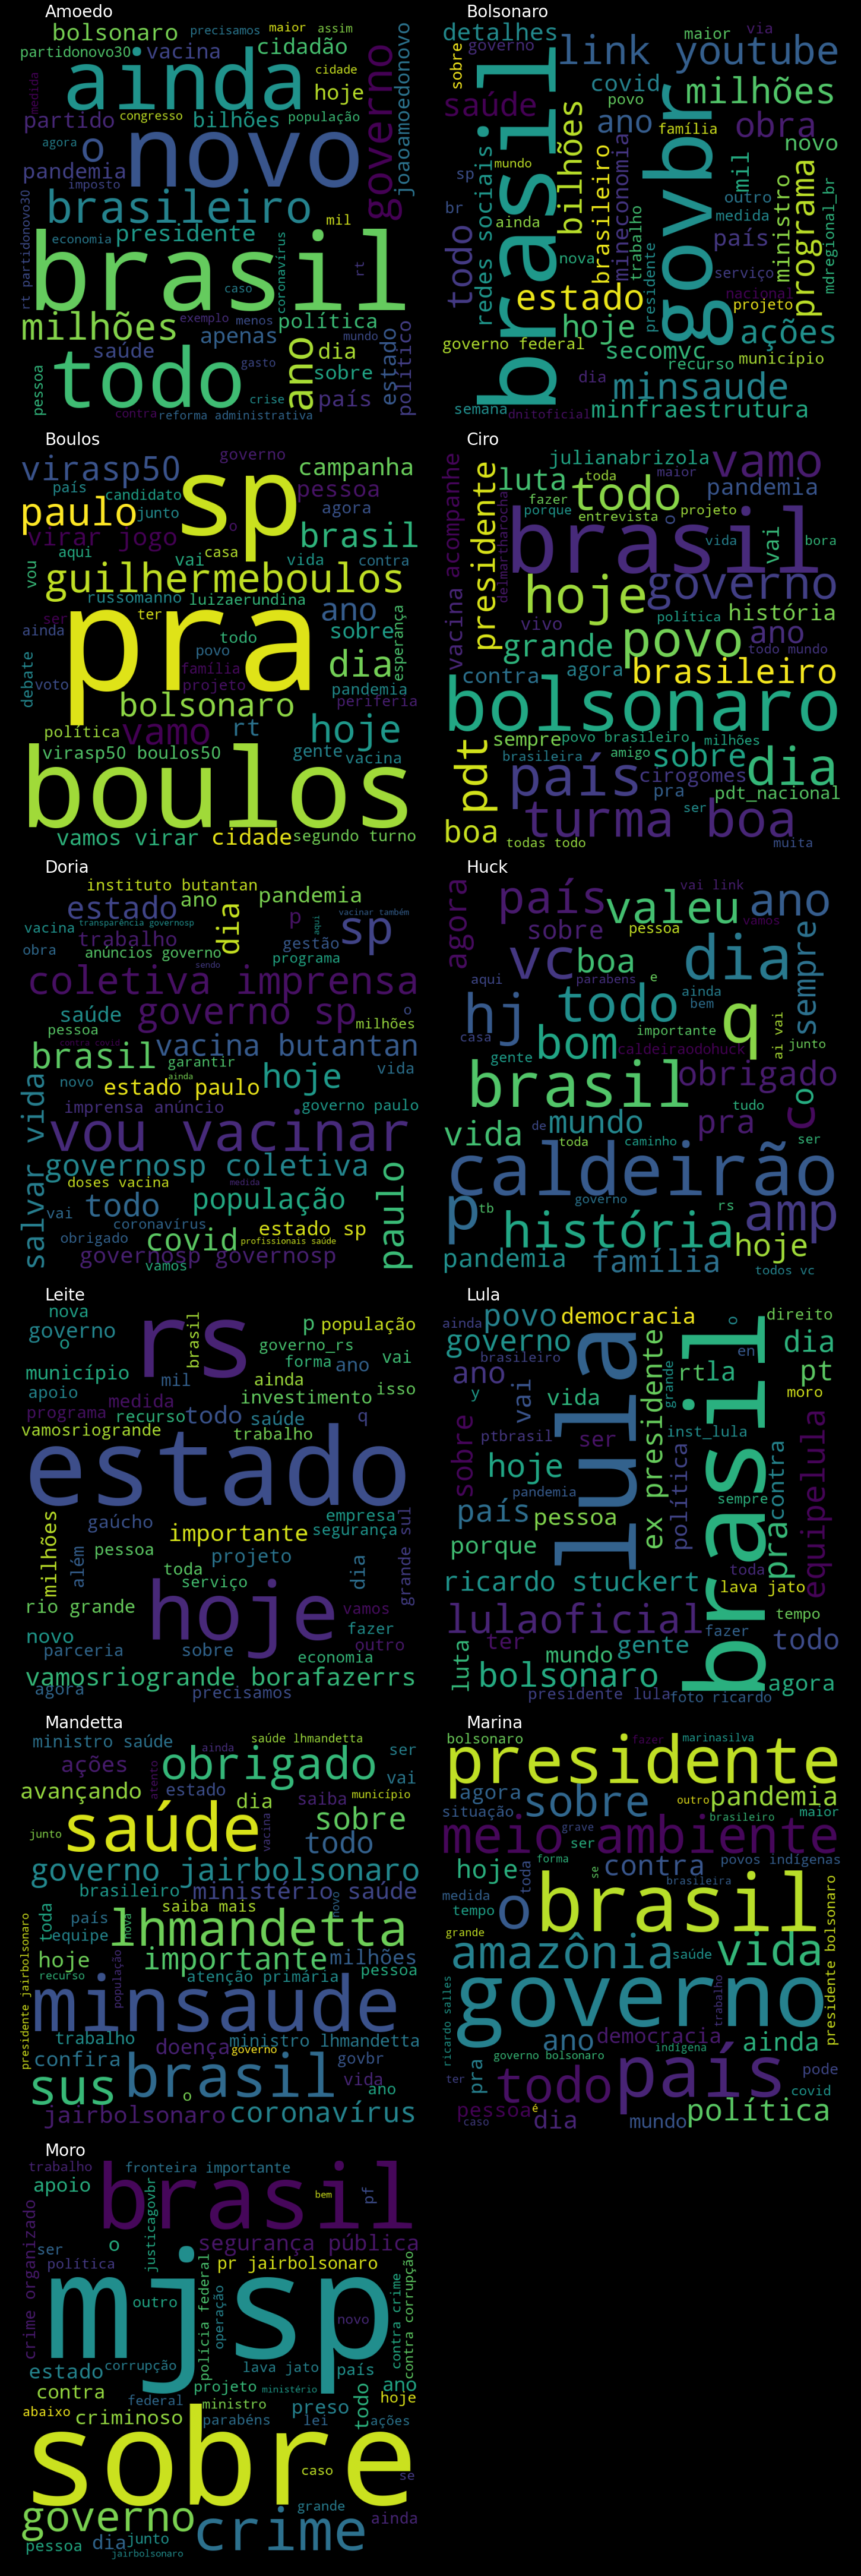

In [13]:
palavras = []
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='k')
xc = 0
yc = 0
for idx in range(11):
    palavras.append("".join(politicos[nome_politicos[idx]]['text']).lower().split())
    palavras[idx] = [w for w in palavras[idx] if not w in (stop_words | symbols)]
    palavras[idx] = [w for w in palavras[idx] if re.match(r'https://*', w) == None]
    sumario = " ".join(s for s in palavras[idx])
    wordcloud = WordCloud(width=800, height=800, max_words=50).generate(sumario)
    ax[xc][yc].imshow(wordcloud)
    ax[xc][yc].text(50, -10, nome_politicos[idx], fontsize=28, color='white')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.axis('off')
plt.tight_layout(pad=0) 
plt.show()

Criando conjunto de palavras únicas com as palavras de todos os políticos

In [7]:
palavras_unicas = set()
numero_total_palavras = 0
for c in palavras:
    for p in c:
        palavras_unicas.add(p)
        numero_total_palavras += 1
print(numero_total_palavras, len(palavras_unicas))

508217 85146


## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

In [14]:
# stopwords e simbolos a retirar
stop_words = set(stopwords.words('portuguese'))
symbols = set(['-', 'r$', 'R$', '.'])

for idx in range(len(nome_politicos)):
    politicos[nome_politicos[idx]]['tweet_token'] = 'NaN'
    tweets = politicos[nome_politicos[idx]]['text']
    for index, row in politicos[nome_politicos[idx]].iterrows():
        tweet = row['text'].lower()
        tweet_token = [w for w in tweet.split() if not w in (stop_words | symbols)]
        tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
        tweet_token = [w for w in tweet_token if not w.startswith('@')]
        tweet_token = [w for w in tweet_token if not w.startswith('#')]
        tweet_token = [w for w in tweet_token if w != 'rt']

        politicos[nome_politicos[idx]].loc[index, 'tweet_token'] = emoji(" ".join(tweet_token))

In [30]:
dfp = pd.DataFrame(politicos['Amoedo'])
dfp['nome'] = "Amoedo"
dfp

created_at                                               text  \
0     2021-04-19T16:18:20Z  RT @MBLivre: Presidente americano Joe Biden an...   
1     2021-04-19T16:05:53Z  Temos que fazer a nossa parte. Não podemos dei...   
2     2021-04-19T15:32:40Z  O governo federal e o Congresso ignoraram no O...   
3     2021-04-19T12:53:14Z  RT @o_antagonista: .@joaoamoedonovo sugeriu no...   
4     2021-04-19T12:25:58Z                     Informações de @OGloboPolitica   
...                    ...                                                ...   
3190  2020-03-08T17:58:56Z  ✅O governo Bolsonaro começou bem, com nomeaçõe...   
3191  2020-03-08T17:58:55Z  ✅O estado gerou mais de 100 mil emprego formai...   
3192  2020-03-08T17:58:54Z  ✅Zema assumiu com um deficit previsto de R$15 ...   
3193  2020-03-08T17:58:53Z  ✅A ação do NOVO no STF pode impedir os aumento...   
3194  2020-03-08T17:58:53Z  ✅O resultado das pessoas que foram eleitas e t...   

                       id                                        tweet_token  \
0     1384179569712713735  presidente americano joe biden anuncia hoje va...   
1     1384176435552608259  fazer parte. podemos deixar brasil continuar a...   
2     1384168077697314825  governo federal congresso ignoraram orçamento ...   
3     1384127951311040517  .@joaoamoedonovo sugeriu twitter temas serem i...   
4     1384121090243383296                                        informações   
...                   ...                                                ...   
3190  1236713021919105024  o governo bolsonaro começou bem, nomeações, es...   
3191  1236713019062837250  o estado gerou 100 mil emprego formais 2019 at...   
3192  1236713016542068737  zema assumiu deficit previsto r$15 bilhões fec...   
3193  1236713012456763394  a ação novo stf pode impedir aumento salários ...   
3194  1236713010305077248  o resultado pessoas eleitas têm sido destaque ...   

        nome  
0     Amoedo  
1     Amoedo  
2     Amoedo  
3     Amoedo  
4     Amoedo  
...      ...  
3190  Amoedo  
3191  Amoedo  
3192  Amoedo  
3193  Amoedo  
3194  Amoedo  

[3195 rows x 5 columns]

In [15]:
tweets = list()
for politico in nome_politicos:
    tweets.extend(list(politicos[politico]['tweet_token']))

tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(tweets)

lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

n_top_words = 3
print("\nTópico no Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Tópico no Modelo LDA: 
**********************************************************************

Topic #0:importante quer empresas

Topic #1:vivo la the

Topic #2:ser política novo

Topic #3:rio entrevista grande

Topic #4:presidente bolsonaro lula

Topic #5:dia obrigado todos

Topic #6:ricardo foto espero

Topic #7:brasil vamos todos

Topic #8:link criminosos aniversário

Topic #9:saúde governo milhões


## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos Politicos

In [17]:
tf_vectorizer = CountVectorizer()
for politico in nome_politicos:
    tf = tf_vectorizer.fit_transform((list(politicos[politico]['tweet_token'])))
    lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)
    lda.fit(tf)

    n_top_words = 3
    print(f"\nTópico no Modelo LDA: {politico}")
    print("*"*70)
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)


Tópico no Modelo LDA: Amoedo
**********************************************************************

Topic #0:link bolsonaro questiona

Topic #1:ficam expectativas pequenas

Topic #2:debate havia quantos

Topic #3:gastos reforma tributária

Topic #4:contra 2018 acredito

Topic #5:brasil novo ser

Topic #6:queiroz 89 recebeu

Topic #7:brasil lugar ranking

Topic #8:conta informações fonte

Topic #9:novo impeachment se

Tópico no Modelo LDA: Bolsonaro
**********************************************************************

Topic #0:visitas miséria fome

Topic #1:br todos dia

Topic #2:ministro the crianças

Topic #3:youtube link 2020

Topic #4:ministra marajó mim

Topic #5:brasil governo ações

Topic #6:doses vacina contra

Topic #7:milhões bilhões covid

Topic #8:boa noite todos

Topic #9:povo democracia energia

Tópico no Modelo LDA: Boulos
**********************************************************************

Topic #0:aulas show américa

Topic #1:vivo youtube acompanhe

Topic #2:boul